In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Covid/control human lung infection timecourse dataset overview

Read position csv comes from timp3_timp2_10X_readzs_other_samples.ipynb (near bottom of the notebook)

In [22]:
#each row represents a single read and includes the starting position of the read
df = pd.read_csv('krasnow_covid_10X_3prime_timp2_timp3_read_positions.csv')

#rename the gene column to just Timp2/Timp3, I already know it is the 3' UTR and from hg38
df['gene'] = df['gene'].replace({'Timp2_3UTR_hg38':'Timp2','Timp3_3UTR_hg38':'Timp3'})
df

,gene,f_name,infection,culture_time,compartment,free_annotation,pos
0,Timp2,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852516
1,Timp2,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
2,Timp2,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852526
3,Timp2,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852530
4,Timp2,0h_noncultured_Sample_1_S1,noncultured,0,Immune,Macrophage,78852568
...,...,...,...,...,...,...,...
401715,Timp3,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963
401716,Timp3,96h_infected_Sample_2_S10,infected,96,NaN,NaN,32862963
401717,Timp3,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 1,32862964
401718,Timp3,96h_infected_Sample_2_S10,infected,96,NaN,NaN,32862966


In [23]:
#There are timepoints at 0, 24, 72, and 96 hours (no 48 hours I guess)
#'noncultured' is just for 0-culture time
df[['infection','culture_time']].drop_duplicates().reset_index(drop=True)

,infection,culture_time
0,noncultured,0
1,cultured,24
2,infected,24
3,cultured,72
4,infected,72
5,cultured,96
6,infected,96


In [24]:
#Each row is either a read from Timp2 or Timp3, and comes from either the Immune/Stromal/Endothelial/NaN compartment
df[['gene','compartment']].drop_duplicates().reset_index(drop=True)

,gene,compartment
0,Timp2,Immune
1,Timp2,NaN
2,Timp2,Stromal
3,Timp2,Endothelial
4,Timp2,Epithelial
5,Timp3,Epithelial
6,Timp3,Endothelial
7,Timp3,Stromal
8,Timp3,NaN
9,Timp3,Immune


In [25]:
#There are 61 different cell-types which have reads from either Timp3/Timp2
#including pericytes
sorted(df['free_annotation'].dropna().unique())

['Adventitial Fibroblast',
 'Airway Smooth Muscle',
 'Alveolar Epithelial Type 1',
 'Alveolar Epithelial Type 2',
 'Alveolar Fibroblast',
 'Artery',
 'B',
 'Basal',
 'CCL4+ Natural Killer',
 'CD4+ Effector/Memory T',
 'CD4+ Naive T',
 'CD8+ Effector/Memory T',
 'CD8+ GZMK+ T',
 'CD8+ tissue resident memory T',
 'CEBPB+ Fibroblast',
 'CLEC9A+ Dendritic',
 'CXCL10+ IER3+ Macrophage',
 'CXCL10+ Macrophage',
 'CXCR4+ Macrophage',
 'Capillary Aerocyte',
 'Ciliated',
 'Club',
 'Differentiating Basal',
 'Dying Fibroblast',
 'Dying Macrophage',
 'EREG+ Dendritic',
 'GBP1+ Fibroblast',
 'Gamma Delta T',
 'General Capillary',
 'IER3+ Macrophage',
 'Intermediate Monocyte',
 'Lipofibroblast',
 'Low Quality Capillary',
 'Low Quality Epithelial',
 'Low Quality Natural Killer/T',
 'Low Quality Stromal',
 'Lymphatic',
 'Macrophage',
 'Mast/Basophil',
 'Mesothelial',
 'Mucous',
 'Myeloid Dendritic 1',
 'Myeloid Dendritic 2',
 'Myofibroblast',
 'Natural Killer',
 'Natural Killer T',
 'Neutrophil',
 'Non

In [26]:
#top 20 cell-types by timp3+timp2 summed by read count (number of rows)
df['free_annotation'].value_counts().head(20)

Macrophage                    121737
Alveolar Epithelial Type 1     56606
Lymphatic                      21291
Capillary Aerocyte             18993
General Capillary              16802
Alveolar Fibroblast            14284
IER3+ Macrophage               11458
Adventitial Fibroblast          6909
Vein                            6893
Artery                          5784
CXCL10+ Macrophage              5347
Proliferating Macrophage        4866
Airway Smooth Muscle            4729
CEBPB+ Fibroblast               3713
Alveolar Epithelial Type 2      2904
CXCL10+ IER3+ Macrophage        2715
Mesothelial                     2629
Mast/Basophil                   1626
Differentiating Basal           1604
Basal                           1510
Name: free_annotation, dtype: int64

## Pericyte invesitigation

In [27]:
#looking at metadata to see how many cells are pericytes
meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/COVID_10x/Infection_3/droplet-infection_3_3prime-adata-metadata.2021-02-03_modified.csv',
)

#renaming to match the renaming I did earlyier
meta_df['channel'] = meta_df['channel'].str.replace('Covid19_Pilot2_','').str.replace('_3prime','')
meta_df.head()

,channel,cultured,infected,culture_time,chemistry,n_counts,n_genes,predicted_doublets,viral_sense_umis,viral_antisense_umis,viral_total_umis,free_annotation,compartment,barcode,cell
0,0h_noncultured_Sample_1_S1,False,False,0,3prime,1158,658,False,NaN,NaN,NaN,CD4+ Effector/Memory T,Immune,AAACCCACAATCGAAA,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
1,0h_noncultured_Sample_1_S1,False,False,0,3prime,811,537,False,NaN,NaN,NaN,Capillary Aerocyte,Endothelial,AAACCCACACCCAACG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
2,0h_noncultured_Sample_1_S1,False,False,0,3prime,900,550,False,NaN,NaN,NaN,General Capillary,Endothelial,AAACCCAGTGTACATC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
3,0h_noncultured_Sample_1_S1,False,False,0,3prime,26740,4976,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCAGTTCGATTG,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...
4,0h_noncultured_Sample_1_S1,False,False,0,3prime,27266,5516,False,NaN,NaN,NaN,Macrophage,Immune,AAACCCATCATCGCTC,Covid19_Pilot2_0h_noncultured_Sample_1_3prime_...


In [28]:
#only 172 cells are Pericytes by free_annotation
#the highest number of Pericytes come from uncultured t=0 sample, but even still it's only 76 cells
meta_df[
    meta_df['free_annotation'].eq('Pericyte')
].groupby(
    ['culture_time','infected']
).size().reset_index(name='num_pericyte_cells')

,culture_time,infected,num_pericyte_cells
0,0,False,76
1,24,False,8
2,24,True,24
3,72,False,23
4,72,True,27
5,96,False,7
6,96,True,7


In [29]:
#there are 672 reads from pericytes (579 of which are Timp3!)
df[df['free_annotation'].eq('Pericyte')].groupby('gene').size()

gene
Timp2     93
Timp3    579
dtype: int64

In [31]:
#the vast majority (497/579 = 85.8%) of Pericyte/Timp3 reads are from 0-hour uncultured tissue
df[
    df['free_annotation'].eq('Pericyte')
    & df['gene'].eq('Timp3')
].groupby(
    ['infection','culture_time']
).size().reset_index(name='num_reads').sort_values('culture_time')

,infection,culture_time,num_reads
5,noncultured,0,497
0,cultured,24,7
3,infected,24,3
1,cultured,72,29
4,infected,72,34
2,cultured,96,9


## Timp3 read buildup plots aggregated over all cell-types

In [86]:
%%time

stratify_by = ['infection','culture_time']
step = 50 #bps to space the points in the graph by

plot_df = df[df['gene'].eq('Timp3')].copy()
plot_df['Category'] = plot_df[stratify_by].apply(lambda r: ' '.join(str(v) for v in r), axis=1)

#convert the min/max to round numbers using the 'step'
min_pos,max_pos = plot_df['pos'].min(),plot_df['pos'].max()
min_pos = (min_pos//step)*step
max_pos = (max_pos//step)*step+step

#shift so that the min-pos is 0 (helps with plotting xticks to have smaller numbers)
#get a list of the x_positions for plotting
x_positions = np.arange(0,max_pos-min_pos+step,step)
print(len(x_positions))

#make a new table with the number of counts of positions <= the 'x_positions'
data = {
    'Category':[],
    'Position':[],
    'Cumulative count':[],
    'Total count':[],
}
for x_pos in x_positions:
    for category,g in plot_df.groupby('Category'):
        data['Category'].append(category)
        data['Position'].append(x_pos)
        data['Cumulative count'].append(g['pos'].sub(min_pos).le(x_pos).sum())
        data['Total count'].append(len(g))

eCDF_df = pd.DataFrame(data)
eCDF_df['eCDF'] = eCDF_df['Cumulative count'].div(eCDF_df['Total count'])
eCDF_df

82
CPU times: user 6.01 s, sys: 9.96 ms, total: 6.02 s
Wall time: 6.01 s


,Category,Position,Cumulative count,Total count,eCDF
0,cultured 24,0,0,10725,0.0
1,cultured 72,0,0,47423,0.0
2,cultured 96,0,0,29845,0.0
3,infected 24,0,0,13301,0.0
4,infected 72,0,0,34549,0.0
...,...,...,...,...,...
569,cultured 96,4050,29845,29845,1.0
570,infected 24,4050,13301,13301,1.0
571,infected 72,4050,34549,34549,1.0
572,infected 96,4050,28054,28054,1.0


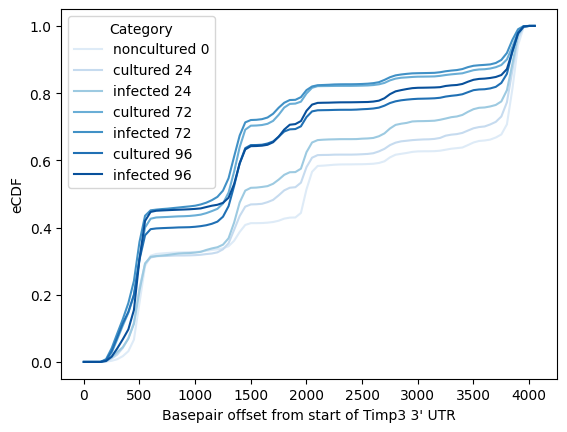

CPU times: user 744 ms, sys: 72 ms, total: 816 ms
Wall time: 831 ms


,gene,f_name,infection,culture_time,compartment,free_annotation,pos,Category
27694,Timp3,0h_noncultured_Sample_1_S1,noncultured,0,Epithelial,Alveolar Epithelial Type 2,32859148,noncultured 0
27695,Timp3,0h_noncultured_Sample_1_S1,noncultured,0,Endothelial,General Capillary,32859148,noncultured 0
27696,Timp3,0h_noncultured_Sample_1_S1,noncultured,0,Endothelial,General Capillary,32859169,noncultured 0
27697,Timp3,0h_noncultured_Sample_1_S1,noncultured,0,Stromal,Airway Smooth Muscle,32859177,noncultured 0
27698,Timp3,0h_noncultured_Sample_1_S1,noncultured,0,Stromal,Alveolar Fibroblast,32859177,noncultured 0
...,...,...,...,...,...,...,...,...
401715,Timp3,96h_infected_Sample_2_S10,infected,96,Immune,Macrophage,32862963,infected 96
401716,Timp3,96h_infected_Sample_2_S10,infected,96,NaN,NaN,32862963,infected 96
401717,Timp3,96h_infected_Sample_2_S10,infected,96,Epithelial,Alveolar Epithelial Type 1,32862964,infected 96
401718,Timp3,96h_infected_Sample_2_S10,infected,96,NaN,NaN,32862966,infected 96


In [90]:
%%time
hue_order = [
    'noncultured 0',
    'cultured 24',
    'infected 24',
    'cultured 72',
    'infected 72',
    'cultured 96',
    'infected 96',
]

sns.lineplot(
    x = 'Position',
    y = 'eCDF',
    hue = 'Category',
    hue_order = hue_order,
    palette = 'Blues',
    data = eCDF_df,
)
plt.xlabel("Basepair offset from start of Timp3 3' UTR")
plt.show()
plt.close()

# Fraction of reads in the full-length 3' UTR region of Timp3

Aggregated over all cell-types and compartments

Reads within chr22:32,862,612-32,863,066 I'm considering within the full-length region of Timp3 3' UTR

How does the fraction of reads in this region change over timepoints? (it decreases which matches visually interpretation)

In [110]:
#min and max boundary of the "full-length" 3' UTR region
b_min,b_max = (32862612,32863066)

agg_df = df[df['gene'].eq('Timp3')].groupby(['infection','culture_time']).agg(
    num_full_length = ('pos', lambda ps: ps.between(b_min,b_max).sum()),
    num_total = ('pos','size'),
)

agg_df['percent_full_length'] = 100*agg_df['num_full_length'] / agg_df['num_total']
agg_df = agg_df.reset_index()
agg_df['infection'] = agg_df['infection'].replace({'cultured':'not infected','noncultured':'not infected'})
agg_df

,infection,culture_time,num_full_length,num_total,percent_full_length
0,not infected,24,3204,10725,29.874126
1,not infected,72,6095,47423,12.852413
2,not infected,96,5613,29845,18.807170
3,infected,24,3225,13301,24.246297
4,infected,72,3998,34549,11.571970
5,infected,96,4389,28054,15.644828
6,not infected,0,8477,24887,34.061960


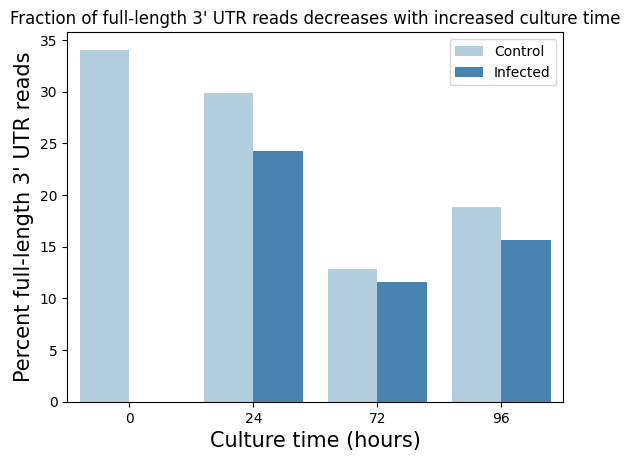

In [119]:
agg_df['State'] = np.where(agg_df['infection'].eq('infected'),'Infected','Control')

ax = sns.barplot(
    x = 'culture_time',
    y = 'percent_full_length',
    hue = 'State',
    palette = 'Blues',
    data = agg_df,
)
ax.legend_.set_title(None)
plt.title("Fraction of full-length 3' UTR reads decreases with increased culture time")
plt.xlabel('Culture time (hours)',fontsize=15)
plt.ylabel("Percent full-length 3' UTR reads",fontsize=15)
plt.show()
plt.close()

## Fraction of full-length reads stratified by compartment/cell-type

Same plots as above, but stratified

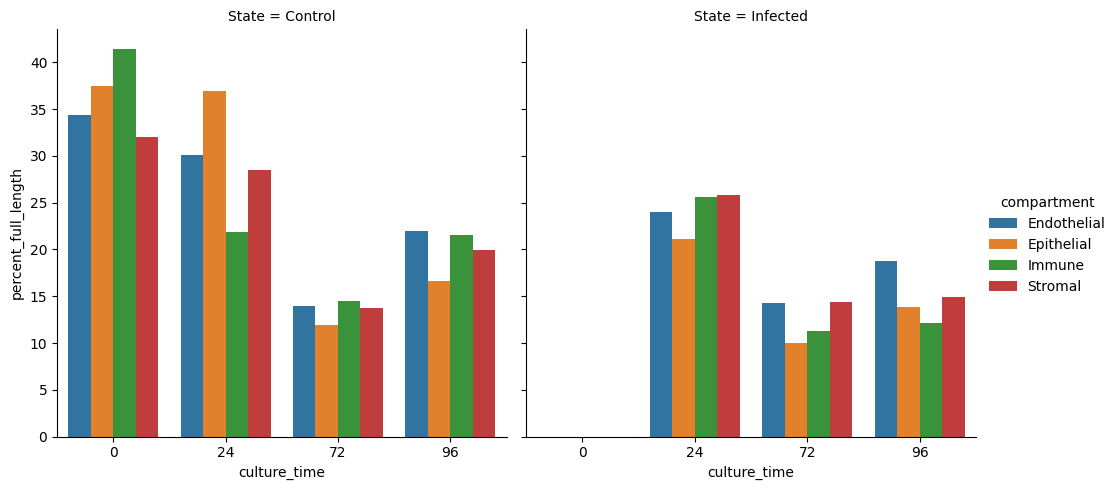

In [126]:
#stratifying just by compartment (the trend is consistent across compartments, not compartment-driven)
#min and max boundary of the "full-length" 3' UTR region
b_min,b_max = (32862612,32863066)

agg_df = df[df['gene'].eq('Timp3')].groupby(['infection','culture_time','compartment']).agg(
    num_full_length = ('pos', lambda ps: ps.between(b_min,b_max).sum()),
    num_total = ('pos','size'),
).reset_index()

agg_df['percent_full_length'] = 100*agg_df['num_full_length'] / agg_df['num_total']

agg_df['State'] = 'Infected'
agg_df.loc[agg_df['infection'].ne('infected'),'State'] = 'Control'

sns.catplot(
    kind = 'bar',
    x = 'culture_time',
    y = 'percent_full_length',
    hue = 'compartment',
    col = 'State',
    data = agg_df,
)
plt.show()
plt.close()

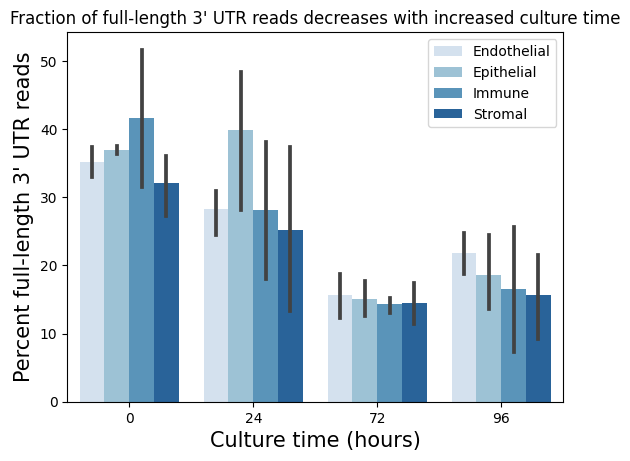

,infection,culture_time,compartment,free_annotation,num_full_length,num_total,percent_full_length
0,cultured,24,Endothelial,Artery,42,200,21.000000
1,cultured,24,Endothelial,Capillary Aerocyte,272,908,29.955947
2,cultured,24,Endothelial,General Capillary,153,494,30.971660
4,cultured,24,Endothelial,Lymphatic,585,1859,31.468531
5,cultured,24,Endothelial,Vein,200,714,28.011204
...,...,...,...,...,...,...,...
158,noncultured,0,Stromal,Airway Smooth Muscle,345,893,38.633819
159,noncultured,0,Stromal,Alveolar Fibroblast,1453,4676,31.073567
161,noncultured,0,Stromal,Myofibroblast,195,531,36.723164
162,noncultured,0,Stromal,Pericyte,113,497,22.736419


In [152]:
#FIGURE PANEL

#filtering to just 'control' (uninfected)
#stratifying by compartment and free_annotation to get multiple data points per compartment 
#min and max boundary of the "full-length" 3' UTR region
b_min,b_max = (32862612,32863066)

agg_df = df[
    df['gene'].eq('Timp3')
    & df['infection'].ne('infected')
].groupby(['infection','culture_time','compartment','free_annotation']).agg(
    num_full_length = ('pos', lambda ps: ps.between(b_min,b_max).sum()),
    num_total = ('pos','size'),
).reset_index()


#hour/compartment/free-annotation must have at least 50 reads to be part of calculation
agg_df = agg_df[agg_df['num_total'].ge(50)] 


agg_df['percent_full_length'] = 100*agg_df['num_full_length'] / agg_df['num_total']

ax = sns.barplot(
    x = 'culture_time',
    y = 'percent_full_length',
    hue = 'compartment',
    palette = 'Blues',
    data = agg_df,
)
ax.legend_.set_title(None)
plt.title("Fraction of full-length 3' UTR reads decreases with increased culture time")
plt.xlabel('Culture time (hours)',fontsize=15)
plt.ylabel("Percent full-length 3' UTR reads",fontsize=15)
plt.savefig('percent_full_length_timp3_UTR_reads.svg')
plt.show()
plt.close()

agg_df

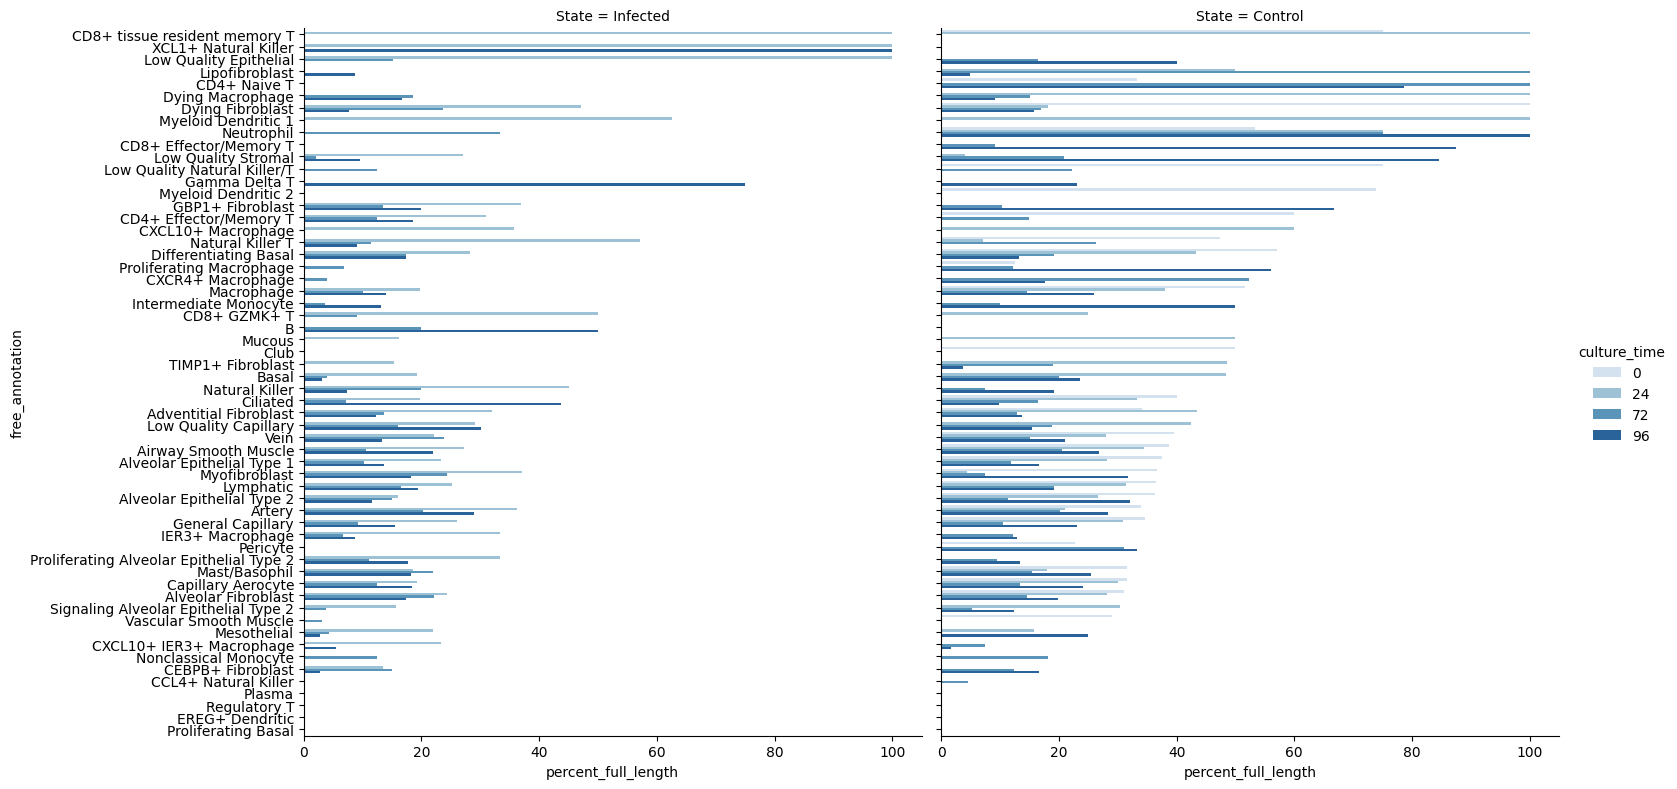

In [141]:
#stratifying by free_annotation (I think the data is too sparse for this to be interesting)
#min and max boundary of the "full-length" 3' UTR region
b_min,b_max = (32862612,32863066)

agg_df = df[df['gene'].eq('Timp3')].groupby(['infection','culture_time','free_annotation']).agg(
    num_full_length = ('pos', lambda ps: ps.between(b_min,b_max).sum()),
    num_total = ('pos','size'),
).reset_index()

agg_df['percent_full_length'] = 100*agg_df['num_full_length'] / agg_df['num_total']

agg_df['State'] = 'Infected'
agg_df.loc[agg_df['infection'].ne('infected'),'State'] = 'Control'
agg_df = agg_df.sort_values('percent_full_length', ascending=False)

g = sns.catplot(
    height = 8,
    kind = 'bar',
    x = 'percent_full_length',
    y = 'free_annotation',
    hue = 'culture_time',
    palette = 'Blues',
    col = 'State',
    data = agg_df,
)
plt.show()
plt.close()

In [129]:
agg_df['free_annotation'].nunique()

58